**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.metrics import pairwise_distances

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
import scipy
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree

%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors,
                 algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.n_classes = len(set(y))

    def kneighbors(self, X):
        if self.algorithm == 'brute':
            dst = pairwise_distances(X, self.X, metric=self.metric)
            dst = dst.argpartition(self.n_neighbors, axis=1)
            return dst[:, :self.n_neighbors]
        if self.algorithm == 'kd_tree':
            tree = KDTree(self.X, metric=self.metric)
            return tree.query(X, k=self.n_neighbors)[1]

    def predict_proba(self, X):
        k_ind = self.kneighbors(X)

        def bins(x):
            return np.bincount(x, minlength=self.n_classes)
        stat = np.apply_along_axis(bins, axis=1, arr=self.y[k_ind])
        return stat/stat.sum(axis=1)[:, None]

    def predict(self, X):
        k_ind = self.kneighbors(X)
        return stats.mode(self.y[k_ind], axis=1)[0].T.flatten()

    def score(self, X, y):
        Y = self.predict(X)
        return np.mean(Y == y)


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [6]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 615 µs, sys: 114 µs, total: 729 µs
Wall time: 508 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 28 µs, sys: 6 µs, total: 34 µs
Wall time: 35.3 µs


In [9]:
%time clf.predict(X_test)

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 1.79 ms


array([1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1])

In [10]:
%time my_clf.predict(X_test)

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 1.28 ms


array([1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1])

In [11]:
%time clf.predict_proba(X_test)

CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 1.06 ms


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ]])

In [12]:
%time my_clf.predict_proba(X_test)

CPU times: user 948 µs, sys: 0 ns, total: 948 µs
Wall time: 677 µs


array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 904 µs, sys: 77 µs, total: 981 µs
Wall time: 886 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 74 µs, sys: 14 µs, total: 88 µs
Wall time: 93.5 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 5.64 ms, sys: 275 µs, total: 5.92 ms
Wall time: 4.67 ms


array([1, 0, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 3.89 ms


array([1, 0, 2, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0])

In [19]:
%time clf.predict_proba(X_test)

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 1.96 ms


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ]])

In [20]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 1.71 ms


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ]])

In [21]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [22]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [23]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [24]:
import re

buf = [re.sub(r"[\W_]", " ", line.lower()) for line in data]
data_tok, target_cut = zip(*[(line.split(), target[i])
                             for i, line in enumerate(buf)
                             if len(line) and not line.isspace()])

data_tok = np.array(data_tok)
target_cut = np.array(target_cut)


In [25]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [26]:
indptr = [0]
indices = []
c_data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        c_data.append(1)
    indptr.append(len(indices))

vec_form = scipy.sparse.csr_matrix((c_data, indices, indptr))


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [27]:
from sklearn.model_selection import cross_val_score

my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute', metric = 'euclidean')
cross_val_score(my_clf, vec_form, target_cut, cv= 3)


array([0.18738102, 0.19274809, 0.19486198])

In [28]:
from tqdm import tqdm

def mean_scores(alg, m='euclidean', csr=vec_form, trg=target):
    res = []
    for i in tqdm(range(2, 11)):
        my_clf = MyKNeighborsClassifier(n_neighbors=i,
                                        algorithm=alg,
                                        metric=m)
        my_clf.fit(csr, trg)
        res.append(np.array(cross_val_score(my_clf, csr, trg, cv=3)))
    return np.array(res).mean(axis=1)


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

100%|██████████| 9/9 [01:01<00:00,  6.82s/it]


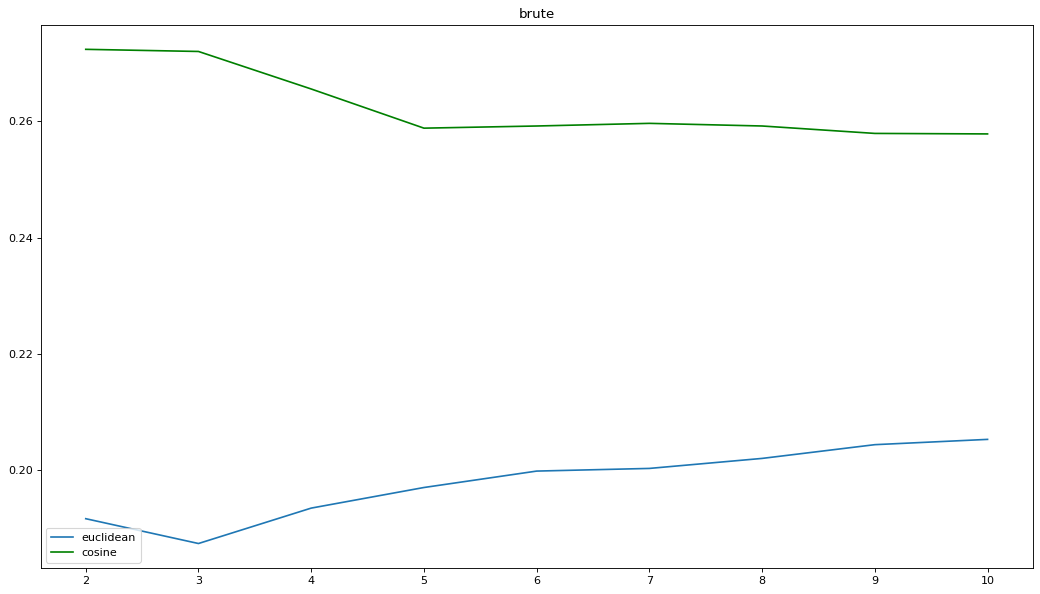

Euclidean:
10 0.2052987278695836

Cosine:
2 0.27235862071819067


In [29]:
plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(111)
plt.title('brute')

euclidean = mean_scores('brute', trg=target_cut)
cosine = mean_scores('brute', 'cosine', trg=target_cut)

plt.plot(np.arange(2, 11), euclidean)
plt.plot(np.arange(2, 11), cosine, 'g')

plt.legend(['euclidean', 'cosine'], loc='lower left')
plt.show()

print('Euclidean:')
i_max = np.argmax(euclidean)
print(i_max + 2, euclidean[i_max])

print('\nCosine:')
i_max = np.argmax(cosine)
print(i_max + 2, cosine[i_max])


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

100%|██████████| 9/9 [01:09<00:00,  7.74s/it]


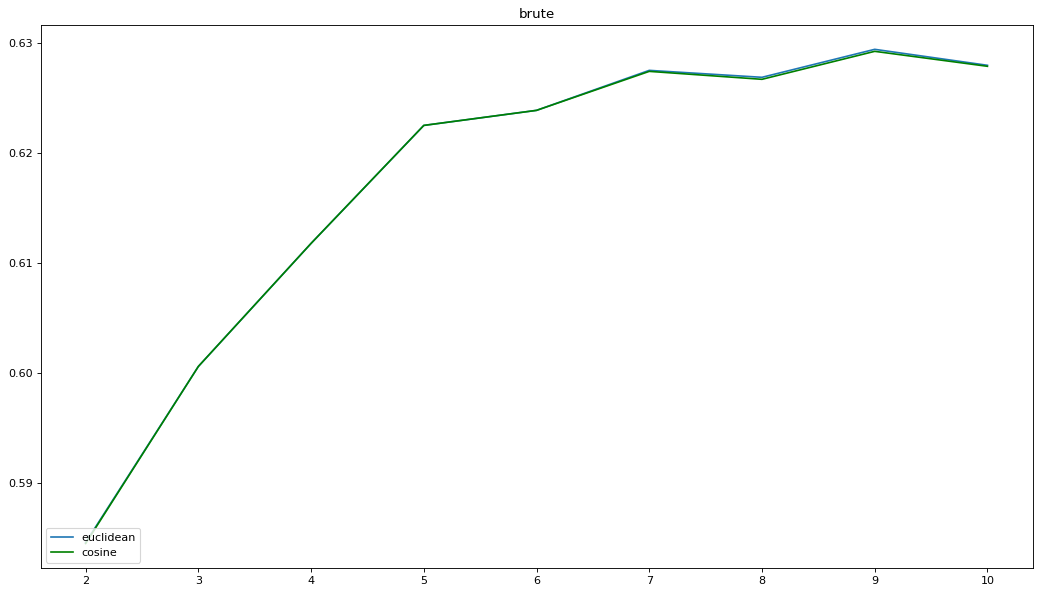

Euclidean:
9 0.6294084763360851

Cosine:
9 0.6292262771924211


In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfid = tfidf_transformer.fit_transform(vec_form)


plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')


plt.subplot(111)
plt.title('brute')

euclidean = mean_scores('brute', csr=tfid, trg=target_cut)
cosine = mean_scores('brute', 'cosine', csr=tfid, trg=target_cut)

plt.plot(np.arange(2, 11), euclidean)
plt.plot(np.arange(2, 11), cosine, 'g')

plt.legend(['euclidean', 'cosine'], loc='lower left')
plt.show()

print('Euclidean:')
i_max = np.argmax(euclidean)
print(i_max + 2, euclidean[i_max])

print('\nCosine:')
i_max = np.argmax(cosine)
print(i_max + 2, cosine[i_max])


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [32]:
test_data = newsgroups['data']
test_target = newsgroups['target']

buf = [re.sub(r"[\W_]", " ", line.lower()) for line in test_data]
test_data_tok, test_target_cut = zip(*[(line.split(), test_target[i])
                                       for i, line in enumerate(buf)
                                       if len(line) and not line.isspace()])

test_data_tok = np.array(test_data_tok)
test_target_cut = np.array(test_target_cut)


In [33]:
indptr = [0]
indices = []
c_data = []
for d in test_data_tok:
    for term in d:
        if term in vocabulary:
            index = vocabulary[term]
            indices.append(index)
            c_data.append(1)
    indptr.append(len(indices))

test_vec_form = scipy.sparse.csr_matrix((c_data, indices, indptr))
test_tfid = tfidf_transformer.fit_transform(test_vec_form)


In [34]:
my_clf = MyKNeighborsClassifier(n_neighbors=9, algorithm='brute', metric = 'euclidean')
my_clf.fit(tfid, target_cut)

print(my_clf.score(test_tfid, test_target_cut))


0.5732658366397592


Качество понизилось из за несовпадения множеств слов встречающихся в тренировочной и тестовой выборках.